# Unstructured Data Analytics HW3

Name: Mingwei Gao

Andrew ID: mingweig

Reminder: you should not be sharing code.

### Instructions

1. Fill in your name and Andrew ID above.
2. Fill in the code/text blocks to answer each question.
3. Do *not* change any of the existing code provided.
4. Run the entire notebook *before* submitting it on Canvas to make sure that the code actually runs without errors. (**Important**: Any code cells that you have entered code for but did not actually execute will be disregarded, so please be sure to actually run your code first and make sure it runs without errors! We may re-run a subset of your code for grading purposes).
5. Be careful about where you save data for use with this Jupyter notebook (more details on this later).
6. You are encouraged to seek assistance from ChatGPT in developing your code.

### **Part 1 (55 points)**: Time Series Data Analysis

The Air Quality UCI dataset provides detailed recordings from a gas multisensor device deployed in a highly polluted area of an Italian city to monitor air quality. This dataset captures hourly averages of gas concentrations and sensor responses over the span of one year, from March 2004 to February 2005, making it one of the longest publicly available datasets of its kind. It includes data from five metal oxide chemical sensors on key pollutants such as CO, Non Methanic Hydrocarbons, Benzene, NOx, and NO2, with ground truth provided by a certified reference analyzer. The dataset, comprising 9358 instances, also highlights challenges like cross-sensitivities and sensor drifts that can impact the accuracy of pollution estimation.

##### Load and Preprocess Air Quality Data

In [ ]:
import pandas as pd

# Load data from local file
from google.colab import files
# Select the zip file and upload it to the root dirctory on Colab.
# uploaded = files.upload()

# Read the data
data = pd.read_csv("AirQualityUCI.csv", delimiter=';').loc[:, ['Date', 'Time', 'NOx(GT)']]
data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%d/%m/%Y %H.%M.%S')
data.drop(columns=['Date', 'Time'], inplace=True)
data.dropna(inplace=True)
# Display the first few rows of the dataset to understand its structure
data.head()

,NOx(GT),DateTime
0,166.0,2004-03-10 18:00:00
1,103.0,2004-03-10 19:00:00
2,131.0,2004-03-10 20:00:00
3,172.0,2004-03-10 21:00:00
4,131.0,2004-03-10 22:00:00


##### **Part 1.1 (10 points)**: Data Visualization

Please visualize the time series `NOx(GT)`. What prominent feature(s) can you observe from the time series?

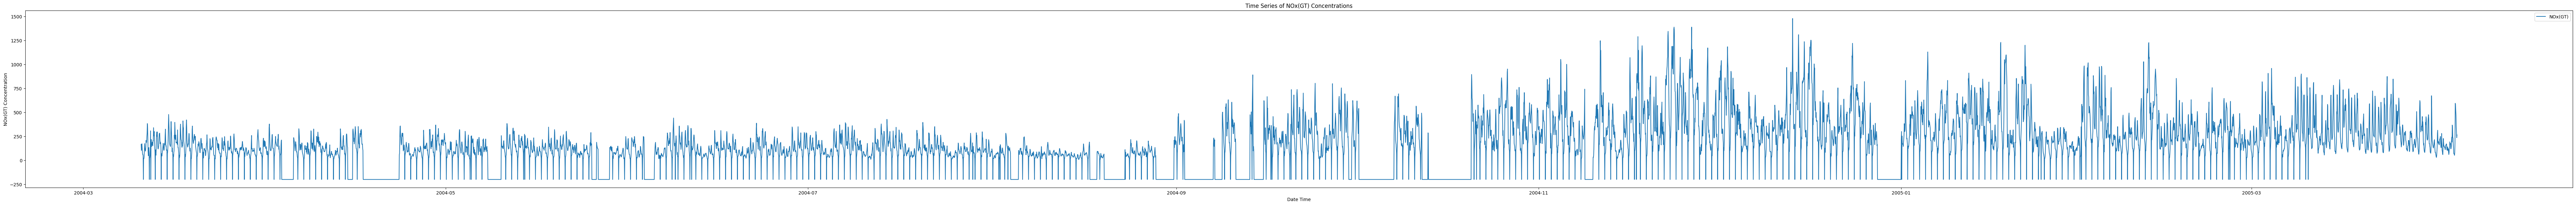

In [ ]:
import matplotlib.pyplot as plt
# Your code here (5 points)


plt.figure(figsize=(100, 7))
plt.plot(data['DateTime'], data['NOx(GT)'], label='NOx(GT)')
plt.title('Time Series of NOx(GT) Concentrations')
plt.xlabel('Date Time')
plt.ylabel('NOx(GT) Concentration')
plt.legend()
plt.show()


**Your discussion here (5 points)**

The plot shows distinct patterns and features. A noticeable cyclical pattern emerges, implying the regular fluctuations in NOx levels which could correspond to daily traffic or industrial activity cycles. Peaks and troughs appear to be recurrent, which might indicate rush hours or systematic emissions from a consistent source.

We can also observe a general trend going up in the latter part of the year, possibly due to seasonal changes impacting emissions or some factors causing this to happen. Some spikes that stand out from the regular patterns, could be attributed to emission events or anomalies in sensor readings. These outliers may warrant further investigation to understand their cause. The absence of data at some time suggests there may be periods of missing data or the sensor was not functioning well.

The visualization provides a compelling overview of NOx fluctuations over time in the monitored area.

##### Preparing for Time-Series Prediction

Code in the following cell prepares a dataset for time series forecasting by creating lagged features of NOx concentrations, cleaning the data, and splitting it into training and test sets.

In [ ]:
nox_data

0       166.0
1       103.0
2       131.0
3       172.0
4       131.0
        ...  
9352    472.0
9353    353.0
9354    293.0
9355    235.0
9356    265.0
Name: NOx(GT), Length: 9357, dtype: float64

In [ ]:
nox_data.shift(1)

0         NaN
1       166.0
2       103.0
3       131.0
4       172.0
        ...  
9352    523.0
9353    472.0
9354    353.0
9355    293.0
9356    235.0
Name: NOx(GT), Length: 9357, dtype: float64

In [ ]:
num_lags = 80  # Number of lagged observations to use as features

# Data Preparation focusing on 'NOx(GT)' column
nox_data = data['NOx(GT)'].dropna().reset_index(drop=True)  # Remove missing values from NOx(GT) and reset the index

# Resetting the DataFrame for lagged data
nox_data_lagged = pd.DataFrame()  # Initialize an empty DataFrame for lagged features

# Create lagged features up to num_lags
for i in range(1, num_lags + 1):
    nox_data_lagged[f'NOx_lag_{i}'] = nox_data.shift(i)  # Create a new column for each lag, shifting the NOx data by i periods

# Include the original NOx data as the target variable
nox_data_lagged['NOx'] = nox_data  # Add the original NOx data as a column to be used as the target variable for prediction

# Drop rows with NaN values due to lagging
nox_data_lagged.dropna(inplace=True)  # Remove the first num_lags rows which now contain NaN values because of the shifting

# Prepare feature and target datasets
X = nox_data_lagged.drop('NOx', axis=1)  # Features are all the lagged NOx columns
y = nox_data_lagged['NOx'].values  # Target variable is the original NOx column

# Splitting the dataset into training and test sets
X_train = X[:int(len(nox_data_lagged) * 0.8)]  # 80% of data for training
y_train = y[:int(len(nox_data_lagged) * 0.8)]
X_test = X[int(len(nox_data_lagged) * 0.8):]  # Remaining 20% for testing
y_test = y[int(len(nox_data_lagged) * 0.8):]

# Aligning DateTime for training and test sets
data_datetime_aligned = data['DateTime'].dropna().reset_index(drop=True)  # Align DateTime column by removing NaN values and resetting index
train_datetime = data_datetime_aligned.loc[X_train.index].values  # Extract DateTime values corresponding to the training set
test_datetime = data_datetime_aligned.loc[X_test.index].values  # Extract DateTime values corresponding to the test set

print(f'Shape of training input: {X_train.shape}, training output: {y_train.shape}')
print(f'Example of training input: {X_train.iloc[0].values} -> output: {y_train[0]}')
print('That is, we predict the NOx concentration at time t using the NOx concentration at times t-1, t-2, ..., t-80.')
print(f'Shape of test input: {X_test.shape}, test output: {y_test.shape}')

Shape of training input: (7421, 80), training output: (7421,)
Example of training input: [ 174.  190.  172.  214.  283.  279.  277.  227.  148.  138.  119.  118.
  153.  239.  296.  250.  295.  256.  139.   53.   62.  109. -200.   83.
  139.  193.  300.  253.  274.  340.  202.  206.  150.  178.  190.  163.
  160.  143.  216.  187. -200.  307.  109.   56.   30.   21. -200.   82.
  133.  122.   47.   94.  240.  351.  383.  281.  243.  193.  184.  207.
  146.  104.   95.  112.  129.  174.   98.   34.   16.   21. -200.   45.
   62.   62.   89.  131.  172.  131.  103.  166.] -> output: 128.0
That is, we predict the NOx concentration at time t using the NOx concentration at times t-1, t-2, ..., t-80.
Shape of test input: (1856, 80), test output: (1856,)


##### **Part 1.2 (10 points)**: Auto-Regressive Model

**Part 1.2.1 (5 points)**: Please use an auto-regressive model to predict the NOx level of the next period given past NOx levels.

Your model should train on `X_train` and `y_train`. Please report the mean squared error (MSE) on the test set. Save your test-set predictions to `y_pred`.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


# Your code here (5 points)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f'The Mean Squared Error (MSE) on the test set is: {mse}')


The Mean Squared Error (MSE) on the test set is: 11117.398521236573


**Part 1.2.2 (5 points)**: Please implement the `visualize` method. It should visualize the time series in the test set and the predicted time series _on the same plot_. Make sure to adjust the line color/style/width/etc so that it's easy to compare the two series.

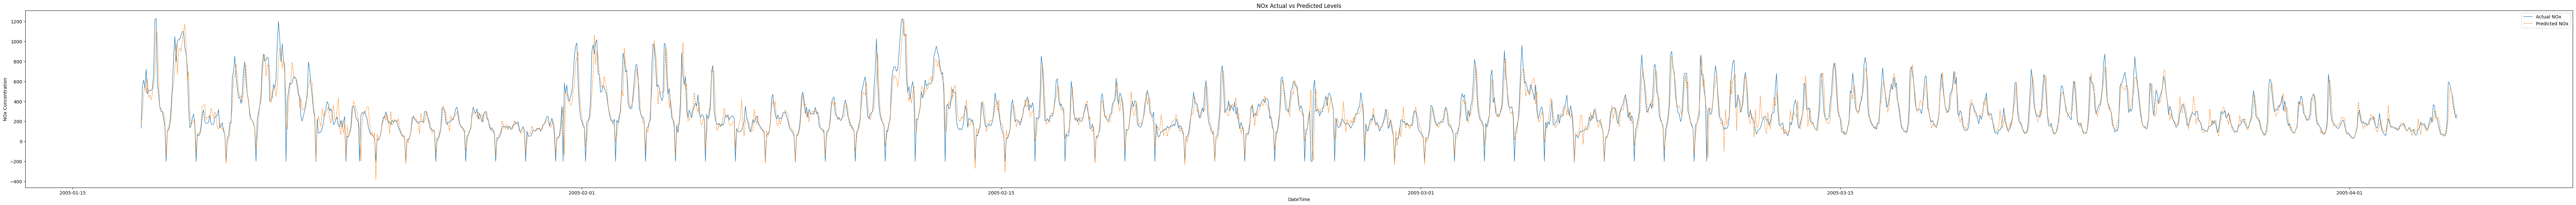

In [ ]:
def visualize(y_test, y_pred, test_datetime):
    # Your code here
    plt.figure(figsize=(100, 7))
    plt.plot(test_datetime, y_test, label='Actual NOx', linewidth=1)
    plt.plot(test_datetime, y_pred, label='Predicted NOx', linestyle='--', linewidth=1)
    plt.title('NOx Actual vs Predicted Levels')
    plt.xlabel('DateTime')
    plt.ylabel('NOx Concentration')
    plt.legend()
    plt.show()

visualize(y_test, y_pred, test_datetime)

### Recurrent Neural Network Modeling

##### **Part 1.3 (35 points)**: Using RNN to model time series data

Code in the following cell prepares the data for RNN training. It reshapes the data and applies min-max scaling.

_Note that you can run the following cell only once. If you need to rerun it, you'll need to rerun the cells above first._

In [ ]:
from sklearn.preprocessing import MinMaxScaler


X_train = X_train.values.reshape(*X_train.shape, 1)
y_train = y_train.reshape(*y_train.shape, 1)
X_test = X_test.values.reshape(*X_test.shape, 1)
y_test = y_test.reshape(*y_test.shape, 1)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(*X_train.shape)
y_train_scaled = scaler.transform(y_train.reshape(-1, 1))
X_test_scaled = scaler.transform(X_test.reshape(-1, 1)).reshape(*X_test.shape)
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))

print(f'Shape of training input: {X_train_scaled.shape}, training output: {y_train_scaled.shape}')
print(f'Example of data before scaling: {X_train[0, :5]} -> {y_train[0]}')
print(f'Example of data after scaling: {X_train_scaled[0, :5]} -> {y_train_scaled[0]}')

Shape of training input: (7421, 80, 1), training output: (7421, 1)
Example of data before scaling: [[174.]
 [190.]
 [172.]
 [214.]
 [283.]] -> [128.]
Example of data after scaling: [[0.22275164]
 [0.23228112]
 [0.22156045]
 [0.24657534]
 [0.28767123]] -> [0.19535438]


##### RNN Model

_Note: `hw3_utils` requires the following packages:_
```
numpy torch torchvision tqdm scikit-learn
```

To work with RNN models, it is usually necessary to use a deep learning library such as `torch`. For the purpose of this homework, in `hw3_utils`, the class `RNNRegressor` has been implemented for you. It wraps a customizable `torch` module into a `sklearn` regressor. You are encouraged to take a look at the implementation if you are interested.

You can initiate an `RNNRegressor` with the following arguments:
- `input_dim`: Specifies the number of input features for the model.
- `hidden_dim`: Determines the size of the hidden layers within the RNN.
- `output_dim`: The size of the output layer. By default, it is set to 1, indicating a single predicted value per input.
- `num_layers`: The number of recurrent layers in the network. Defaults to 1, indicating a single RNN layer.
- `sequence_length`: The length of the input sequences that the model will process. This parameter is crucial for defining how much of the past information the model will consider for making predictions.
- `learning_rate`: Controls the size of the steps the optimizer takes while searching for the model's minimum loss. A smaller learning rate means the model will adjust its weights more gradually during training.
- `num_epochs`: The number of times the entire dataset will be passed forward and backward through the RNN. This parameter defines the length of the training process.
- `batch_size`: The number of samples that will be propagated through the network in one forward/backward pass. It defines how many examples you look at before making a weight update.

**Part 1.3.1 (10 points)**: Please use `RNNRegressor` to fit the **unscaled** training data (`X_train`, `y_train`). Please report the mean squared error (MSE) on the test set and visualize your predictions using the `visualize` method you implemented. For this part, don't worry about tuning the hyperparameters. Your model's performance on the unscaled data is likely pretty bad.

The Mean Squared Error (MSE) on the unscaled test set is: 19595290971.00228


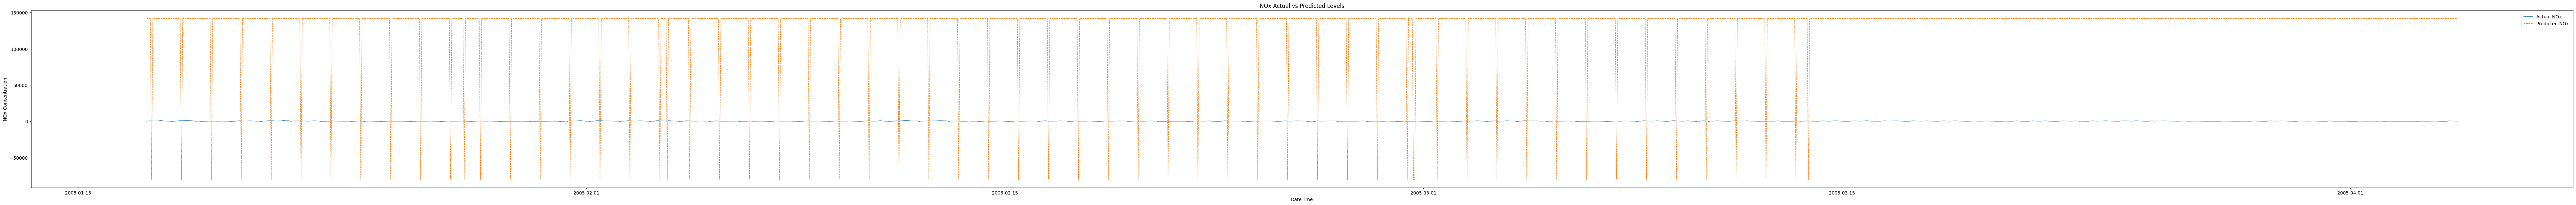

In [ ]:
from hw3_utils import RNNRegressor


# Your code here

rnn_regressor = RNNRegressor(
    input_dim=1,
    hidden_dim=50,
    output_dim=1,
    num_layers=1,
    sequence_length=80,
    learning_rate=0.001,
    num_epochs=10,
    batch_size=32
)


rnn_regressor.fit(X_train, y_train)


y_pred_unscaled = rnn_regressor.predict(X_test)
y_pred_unscaled = scaler.inverse_transform(y_pred_unscaled)


mse_unscaled = mean_squared_error(y_test, y_pred_unscaled)
print(f'The Mean Squared Error (MSE) on the unscaled test set is: {mse_unscaled}')
visualize(y_test, y_pred_unscaled, test_datetime)

**Part 1.3.2 (10 points)**: Now use `RNNRegressor` to fit the **scaled** training data (`X_train_scaled`, `y_train_scaled`). Please report the mean squared error (MSE) on the test set and visualize your **unscaled** predictions using the `visualize` method you implemented.

_Hint: Since your model is trained on the **scaled** data, it should take the scaled data as input for prediction. Its predictions are also scaled. To convert scaled predictions back to unscaled, use `scaler.inverse_transform`._

The Mean Squared Error (MSE) on the test set is: 53878.905037524855


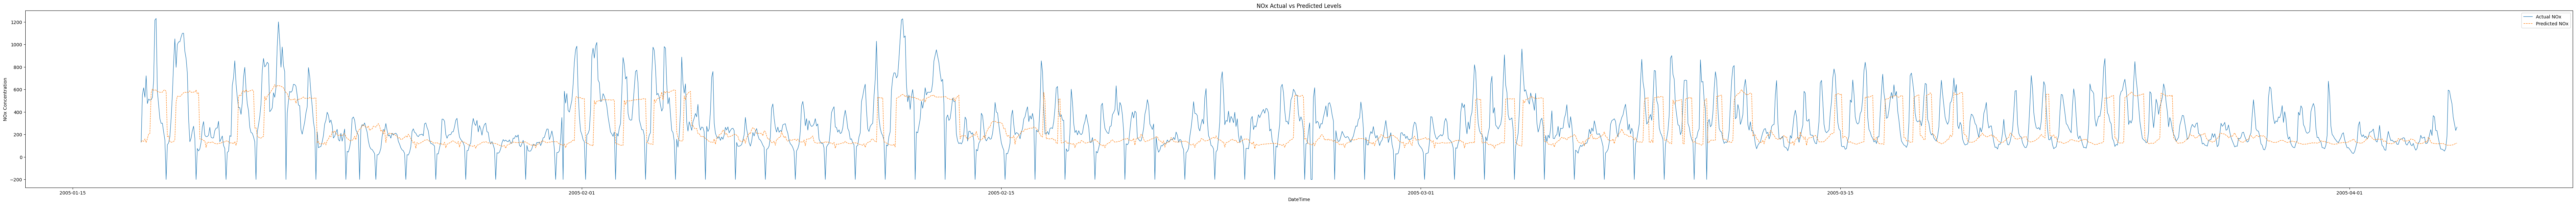

In [ ]:
# Your code here
rnn_regressor_scaled = RNNRegressor(
    input_dim=1,
    hidden_dim=50,
    output_dim=1,
    num_layers=1,
    sequence_length=80,
    learning_rate=0.001,
    num_epochs=10,
    batch_size=32
)

rnn_regressor_scaled.fit(X_train_scaled, y_train_scaled)
y_pred_scaled = rnn_regressor_scaled.predict(X_test_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)

mse_scaled = mean_squared_error(y_test, y_pred)
print(f'The Mean Squared Error (MSE) on the test set is: {mse_scaled}')
visualize(y_test, y_pred, test_datetime)

**Part 1.3.3.1 (10 points)**: Please try to improve your model's performance in **Part 1.3.2** by tuning the hyperparameters. You may copy your code in the previous cell and use the following cell for experimentation.

Briefly discuss **what** you did and **how** your changes affected the predictions.

_This exercise is meant to help you get a flavor of hyperparameter tuning. There is no performance threshold for you to get points. Don't worry too much if you can't seem to get it to work well._

Improved Mean Squared Error (MSE) on the test set is: 49831.70054868316


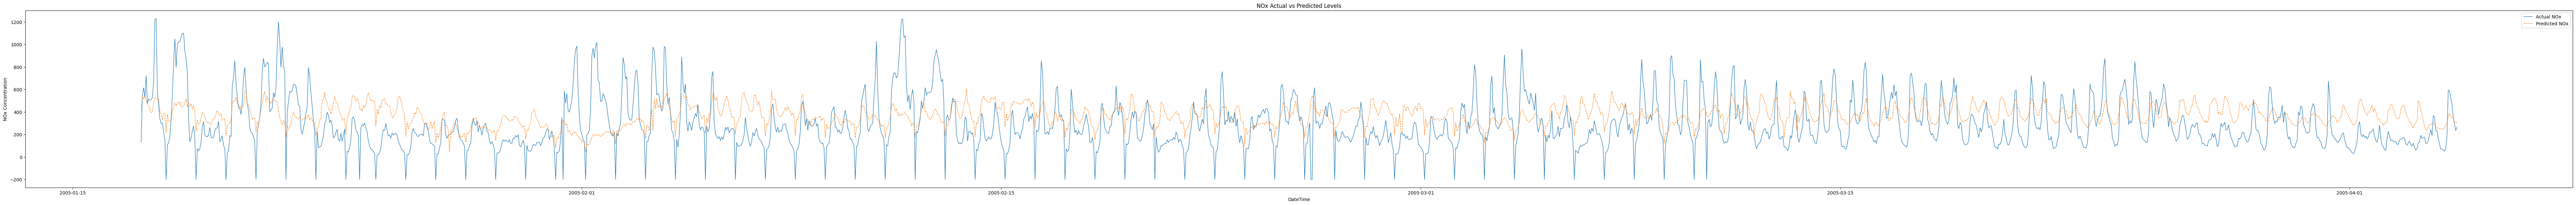

In [ ]:
# Your code here (5 points)

rnn_regressor_tuned = RNNRegressor(
    input_dim=1,
    hidden_dim=64,
    output_dim=1,
    num_layers=3,
    sequence_length=80,
    learning_rate=0.001,
    num_epochs=20,
    batch_size=64
)


rnn_regressor_tuned.fit(X_train_scaled, y_train_scaled)
y_pred_tuned = scaler.inverse_transform(rnn_regressor_tuned.predict(X_test_scaled))


mse_tuned = mean_squared_error(y_test, y_pred_tuned)
print(f'Improved Mean Squared Error (MSE) on the test set is: {mse_tuned}')
visualize(y_test, y_pred_tuned, test_datetime)

**Your discussion here (5 points)**

**Part 1.3.3.2 (5 points)**: Please compare the your predictions across the 3 models (auto-regressive model, RNN model trained on unscaled data, RNN model trained on scaled data).

**Your discussion here**

Comparing the three models, the auto-regressive model likely captured linear trends but missed complex patterns. In addition, the shiftting issue seems exist in this model cause the predicted peaks / troughs often comes after the raw data.

The RNN with unscaled data performed poorly, evidenced by a high MSE, possibly due to training instability from the wide range of input values.

In contrast, the RNN trained on scaled data showed improved accuracy, as normalization helped the model learn underlying patterns more effectively.

Further tuning of hyperparameters in the scaled RNN model led to a reduced MSE, indicating a refined ability to predict NOx levels by better capturing temporal dependencies and avoiding overfitting, demonstrating the importance of data scaling and careful hyperparameter optimization.

### **Part 2 (25 points)**: Image Classification

##### Load CIFAR-10 Data

CIFAR-10 is a dataset consisting of 60,000 32x32 color images in 10 classes, with 6,000 images per class. The dataset is divided into 50,000 training images and 10,000 test images. The classes include airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. CIFAR-10 is widely used for machine learning and computer vision research and applications, serving as a benchmark for evaluating image recognition algorithms.

In [44]:
from hw3_utils import load_and_preprocess_cifar10

# Load and preprocess the CIFAR-10 dataset
X_train, y_train, X_test, y_test = load_and_preprocess_cifar10()

100%|██████████| 170498071/170498071 [00:10<00:00, 15855769.00it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


##### Visualization

You may use the following `visualize_cifar10` to explore the dataset:

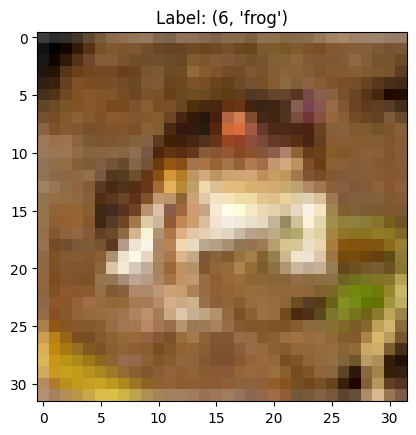

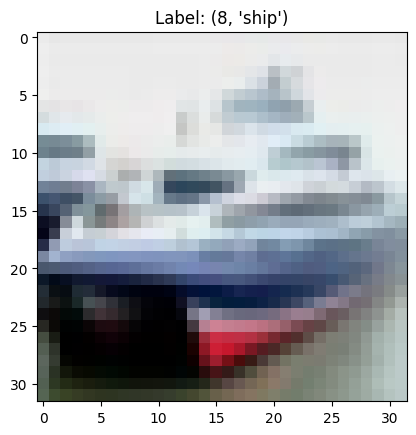

In [47]:
def visualize_cifar10(X, y, index):
    labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']
    plt.imshow((X[index].transpose(1, 2, 0) + 1.0) / 2.0)
    # plt.imshow((X[index].transpose(1, 2, 0)))
    plt.title(f'Label: {y[index], labels[y[index]]}')
    plt.show()

visualize_cifar10(X_train, y_train, 0)
visualize_cifar10(X_test, y_test, 1)

**Part 2.1.1 (10 points)** Please finish the `SimpleCNN` class by filling in the appropriate values/variables in the `...` fields.

In [49]:
import torch
import torch.nn as nn


class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(32 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Similar to **Part 1**, the class `CNNClassifier` has been implemented for you.

You can initiate an `CNNClassifier` with the following arguments:
- `model`: Instance of the CNN model it wraps. You should use initialize `SimpleCNN` you implemented in the previous part and use the instance.
- `learning_rate`: Controls the size of the steps the optimizer takes while searching for the model's minimum loss. A smaller learning rate means the model will adjust its weights more gradually during training.
- `num_epochs`: The number of times the entire dataset will be passed forward and backward through the CNN. This parameter defines the length of the training process.
- `batch_size`: The number of samples that will be propagated through the network in one forward/backward pass. It defines how many examples you look at before making a weight update.

**Part 2.1.2 (10 points)**: Please use `CNNClassifier` to fit the training data. Please report the accuracy score on the test set. Save your `SimpleCNN` instance to `model`.

In [50]:
from hw3_utils import CNNClassifier


# Your code here
model = SimpleCNN(num_classes=10)


cnn_classifier = CNNClassifier(
    model=model,
    learning_rate=1e-3,
    num_epochs=10,
    batch_size=64
)

cnn_classifier.fit(X_train, y_train)

# Evaluate the model on the test set
accuracy = cnn_classifier.score(X_test, y_test)
print(f'Accuracy score on the test set: {accuracy}')


Epoch 10: 100%|██████████| 782/782 [00:54<00:00, 14.37batch/s, loss=0.367]


Accuracy score on the test set: 0.6999


**Part 2.2 (5 points)**: Code in the following cell visualizes the first channels of kernels in the 2 convolutional layers. Please briefly describe what you see. Can you see any difference between the first-layer kernels and the second-layer kernels?

Kernels of the first convolutional layer, first channel:


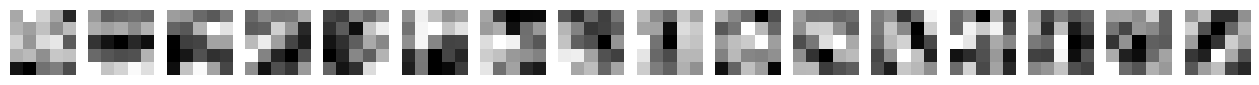

Kernels of the second convolutional layer, first channel:


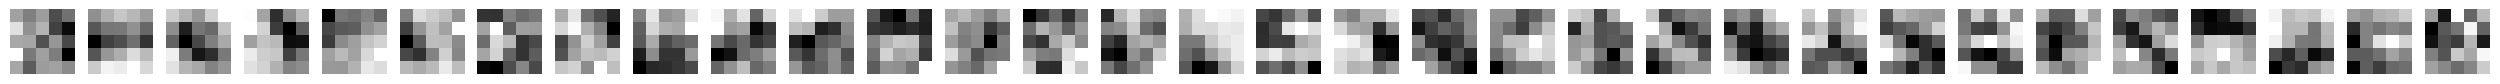

In [51]:
def visualize_kernels(kernels):
    # Normalize the kernels to [0, 1] for visualization
    kernels_min = kernels.min()
    kernels_max = kernels.max()
    kernels = (kernels - kernels_min) / (kernels_max - kernels_min)

    num_kernels = kernels.shape[0]  # Number of kernels in conv1

    # Create a grid for plotting
    fig, axs = plt.subplots(nrows=1, ncols=num_kernels, figsize=(num_kernels, 1))

    for i, ax in enumerate(axs.flat):
        ax.imshow(kernels[i, 0], cmap='gray')
        ax.axis('off')

    plt.show()

print('Kernels of the first convolutional layer, first channel:')
visualize_kernels(model.conv1.weight.data.cpu().numpy())
print('Kernels of the second convolutional layer, first channel:')
visualize_kernels(model.conv2.weight.data.cpu().numpy())

**Your discussion here**

The kernels from the first convolutional layer have more distinct blocks of black and white, which suggests they are likely detecting simple patterns and edges in the input data.

The kernels from the second convolutional layer are more complex, with more varied patterns of gray shades. This indicates that the second layer's kernels are probably extracting more complex features from the data that has been already processed by the first layer.

The difference in complexity is consistent with the intuition of feature learning in CNN, where initial layers capture basic features and subsequent layers build up to more complex representations.

### **Part 3 (20 points)**: Decision Trees

##### Load Data

The `fetch_covtype` method in `sklearn.datasets` loads the forest cover type dataset, which is a classic dataset used for classification tasks. This dataset contains cartographic variables for 30 x 30 meter cells obtained from the US Forest Service (USFS) Region 2 Resource Information System (RIS) data. It includes 581,012 instances and 54 features, predicting forest cover type from cartographic variables. The seven cover types are the labels to predict.

In [52]:
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split

# Fetch the dataset
covtype = fetch_covtype()
X = covtype.data
y = covtype.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f'Shape of training input: {X_train.shape}, training output: {y_train.shape}')
print(f'Shape of test input: {X_test.shape}, test output: {y_test.shape}')

Shape of training input: (406708, 54), training output: (406708,)
Shape of test input: (174304, 54), test output: (174304,)


**Part 3.1 (5 points)**: Use `DecisionTreeClassifier` with the following hyperparameters to fit the training set:
- `max_depth=100`
- `min_samples_split=2`
- `min_samples_leaf=1`

Please report the accuracy scores on the training set **and** the test set. What do you notice about the accuracy scores?

In [53]:
from sklearn.tree import DecisionTreeClassifier


# Train a default decision tree classifier
default_tree = DecisionTreeClassifier(max_depth=100,
                                      min_samples_split=2,
                                      min_samples_leaf=1,
                                      random_state=42)
default_tree.fit(X_train, y_train)

print(f"Default Decision Tree Train Accuracy: {default_tree.score(X_train, y_train):.3f}")
print(f"Default Decision Tree Test Accuracy: {default_tree.score(X_test, y_test):.3f}")

Default Decision Tree Train Accuracy: 1.000
Default Decision Tree Test Accuracy: 0.934


**Your answer here**

The accuracy scores from the decision tree classifier show that it performs perfectly on the training data but slightly worse on unseen test data. This drop from perfect accuracy indicates the model might be overfitting, it's great at remembering the exact details of the training data, including possibly noise and outliers, but it struggles when faced with new data since data in real world could also have certain variance.

To fix this, we could adjust the model through Grid search to find the better hyper parameters, or we could bring in a crowd of models (like a random forest) to get a more well-rounded perspective.

**Part 3.2 (15 points)**: Please use grid search to find the best set of hyperparameters for `DecisionTreeClassifier` that maximizes test set accuracy from the following grid:
```
param_grid = {
    'max_depth': [5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}
```

Report the accuracy scores on the training set **and** the test set using the **best** set of hyperparameters. Please also report the best set of hyperparameters. Compare the accuracy scores and the best set of hyperparameters with the previous part.

In [54]:
from sklearn.model_selection import GridSearchCV


# Define the parameter grid to search
param_grid = {
    'max_depth': [5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Perform grid search
grid_search.fit(X_train, y_train)

# Extract the best parameters and model
best_params = grid_search.best_params_
best_tree = grid_search.best_estimator_

# Evaluate the optimized classifier
print(f"Optimized Decision Tree Train Accuracy: {best_tree.score(X_train, y_train):.3f}")
print(f"Optimized Decision Tree Test Accuracy: {best_tree.score(X_test, y_test):.3f}")

# Print best parameters
print(f"Best Parameters: {best_params}")

Optimized Decision Tree Train Accuracy: 0.999
Optimized Decision Tree Test Accuracy: 0.940
Best Parameters: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}


**Your answer here (5 points)**

Using grid search, the DecisionTreeClassifier got a bit of a tune-up, and it's now hitting an accuracy of 94% on the test set, up from 93.4% previously.

The training accuracy is almost perfect but not 1.0, suggesting the tree is a tad less memorized on the training details and a bit better at handling new data.

The best hyperparameters turned out to be 'entropy' for the criterion with a 'max_depth' of 30, 'min_samples_leaf' of 1, and 'min_samples_split' of 2.

This fine-tuning has made the model slightly more robust to new data while still being quite detailed in its learning — it's like it's learned to pick up on the broader themes of the subject, rather than just the nuance.
